## Chatbot com Tensorflow Keras

- Importações:
Inicialmente, são importadas as bibliotecas necessárias para o funcionamento do código, tais como numpy, pandas, keras e outras.

- Pré-processamento de dados:
Nesta seção, o arquivo de dados é carregado e os dados são limpos, processados e pré-processados. As colunas são renomeadas, os valores nulos são preenchidos e as sentenças são convertidas em sequências de números (tokenização).

- Modelos:
Em seguida, são definidos e compilados dois modelos, um modelo codificador (enc_model) e um modelo decodificador (dec_model). O modelo codificador codifica a entrada de uma sentença em uma representação vetorial. O modelo decodificador, por sua vez, decodifica a representação vetorial codificada e gera a resposta.

- Treinamento:
Nesta seção, o modelo é treinado usando o método fit do Keras. O modelo é alimentado com entradas e saídas (perguntas e respostas, respectivamente) e é treinado para prever a resposta correta para cada pergunta.

- Avaliação:
O modelo treinado é avaliado para verificar sua precisão e erros. Isso é feito usando métricas como a precisão e o erro quadrático médio.

- Predição:
Finalmente, o modelo treinado é usado para fazer previsões. Isso é feito passando uma entrada (uma pergunta) para o modelo codificador, que gera uma representação vetorial codificada. Essa representação vetorial é passada para o modelo decodificador, que gera a resposta.

In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [49]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from collections import Counter

import tensorflow as tf
from tensorflow.keras import layers , activations , models , preprocessing, utils
from tensorflow.keras.models import load_model #Carregar modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense
import re
import pickle

import yaml
import os

In [5]:
dir_path = '/home/archives'
files_list = os.listdir(dir_path + os.sep)

In [6]:
files = os.listdir(dir_path)

for file in files:
    print(file)

saudacoes.yml
perfil.yml
ciencia.yml
computadores.yml


In [7]:
# Cria uma listas vazias para armazenar perguntas e respostas
questions, answers = [], []

# Itera sobre cada arquivo na pasta especificada
for filepath in files_list:
    # Abre o arquivo
    file_ = open(dir_path + os.sep + filepath , 'rb')
    # Carrega o conteúdo do arquivo usando yaml.safe_load()
    docs = yaml.safe_load(file_)
    # extrai a estrutura de dados de conversas
    conversations = docs['conversations']
    # Itera sobre cada conversa
    for con in conversations:
        # Se a conversa tiver mais de uma pergunta e uma resposta
        if len(con) > 2 :
            # Adiciona a primeira linha (a pergunta) na lista de perguntas
            questions.append(con[0])
            # Cria uma string vazia para armazenar as respostas
            replies = con[1 :]
            ans = ''
            # Itera sobre as respostas
            for rep in replies:
                # Concatena as respostas na string 'ans'
                ans += ' ' + rep
            # Adiciona a string 'ans' na lista de respostas
            answers.append(ans)
        # Se a conversa tiver apenas uma pergunta e uma resposta
        elif len(con)> 1:
            # Adiciona a primeira linha (a pergunta) na lista de perguntas
            questions.append(con[0])
            # Adiciona a segunda linha (a resposta) na lista de respostas
            answers.append(con[1])

In [8]:
answers

['Oi',
 'Olá',
 'Olá',
 'Saudações!',
 'Sim, tudo bem!',
 'Bem',
 'Bem e você?',
 'Ótimo',
 'Excelente',
 'Poderia ser melhor.',
 'Não é tão bom.',
 'Bom.',
 'Muito bem, obrigado.',
 'Bem e você?',
 'Obrigada.',
 'Estou indo bem.',
 'Estou indo bem. Como você está?',
 'Obrigada. Você também.',
 'Obrigada. Você também.',
 'Obrigado gentilmente.',
 'E o resto do dia para você.',
 'Obrigado gentilmente.',
 'E o resto do dia para você.',
 'Obrigado gentilmente.',
 'E o resto do dia para você.',
 'Bom dia, em que posso ajudar?',
 'Boa tarde, em que posso ajudar?',
 'Boa noite, em que posso ajudar?',
 'Não muito.',
 'Não muito.',
 'Não muito, e você?',
 'Nada de mais.',
 'O céu está alto, mas estou bem, obrigado. E você?',
 'Sou uma inteligência artificial, e por isso não tenho interesses, desejos ou opiniões próprias.',
 'Como uma IA, não tenho temas favoritos ou desfavoritos.',
 'Eu fui desenvolvido por André Duarte',
 'Eu não tenho nenhum número',
 'Como inteligência artificial, eu não po

In [9]:
questions

['Olá',
 'Oi',
 'Saudações!',
 'Olá',
 'Tudo bem?',
 'E ai como vai?',
 'E ai como vai?',
 'E ai como vai?',
 'E ai como vai?',
 'E ai como vai?',
 'E ai como vai?',
 'Como vai?',
 'Como vai?',
 'Como vai?',
 'Prazer em conhecê-la.',
 'Como vai?',
 'Como vai?',
 'Oi bom conhecê-lo.',
 'É um prazer te conhecer.',
 'Ótima manhã para você!',
 'Ótima manhã para você!',
 'Ótima tarde para você!',
 'Ótima tarde para você!',
 'Ótima noite para você!',
 'Ótima noite para você!',
 'Bom dia',
 'Boa tarde',
 'Boa noite',
 'E aí?',
 'E aí?',
 'E aí?',
 'E aí?',
 'E aí?',
 'Quais são seus interesses',
 'Quais são os seus temas favoritos',
 'Quem te desenvolveu?',
 'Qual é seu número',
 'Qual é o seu número favorito',
 'O que você pode comer',
 'Por que você não pode comer comida',
 'Qual é a sua localização',
 'Qual é a sua localização',
 'De onde você é',
 'Onde você está',
 'Você tem algum irmão',
 'Quem é o teu pai',
 'Quem é sua mãe',
 'Quem é o teu patrão',
 'Qual é a sua idade',
 'Qual é a su

In [10]:
# Cria lista vazia para armazenar respostas com tags
answers_with_tags = []

# Itera sobre cada resposta
for i in range(len(answers)):
    # Verifica se o tipo da resposta é uma string
    if type(answers[i]) == str:
        # Adiciona a resposta à lista answers_with_tags
        answers_with_tags.append(answers[i])
    else:
        # Remove o elemento correspondente da lista de perguntas
        questions.pop(i)

# Cria lista vazia para armazenar as respostas com tags <START> e <END>
answers = []

# Itera sobre cada resposta com tag
for i in range(len(answers_with_tags)) :
    # Adiciona as tags <START> e <END> à resposta e adiciona à lista de respostas
    answers.append('<START> ' + answers_with_tags[i] + ' <END>')

# Cria tokenizer
tokenizer = preprocessing.text.Tokenizer()

# Faz o fit do tokenizer nos dados das perguntas e respostas
tokenizer.fit_on_texts(questions + answers)

# Salva o tamanho do vocabulário na variável VOCAB_SIZE
VOCAB_SIZE = len(tokenizer.word_index)+1

In [11]:
answers

['<START> Oi <END>',
 '<START> Olá <END>',
 '<START> Olá <END>',
 '<START> Saudações! <END>',
 '<START> Sim, tudo bem! <END>',
 '<START> Bem <END>',
 '<START> Bem e você? <END>',
 '<START> Ótimo <END>',
 '<START> Excelente <END>',
 '<START> Poderia ser melhor. <END>',
 '<START> Não é tão bom. <END>',
 '<START> Bom. <END>',
 '<START> Muito bem, obrigado. <END>',
 '<START> Bem e você? <END>',
 '<START> Obrigada. <END>',
 '<START> Estou indo bem. <END>',
 '<START> Estou indo bem. Como você está? <END>',
 '<START> Obrigada. Você também. <END>',
 '<START> Obrigada. Você também. <END>',
 '<START> Obrigado gentilmente. <END>',
 '<START> E o resto do dia para você. <END>',
 '<START> Obrigado gentilmente. <END>',
 '<START> E o resto do dia para você. <END>',
 '<START> Obrigado gentilmente. <END>',
 '<START> E o resto do dia para você. <END>',
 '<START> Bom dia, em que posso ajudar? <END>',
 '<START> Boa tarde, em que posso ajudar? <END>',
 '<START> Boa noite, em que posso ajudar? <END>',
 '<STA

In [12]:
VOCAB_SIZE

671

In [13]:
from gensim.models import Word2Vec
import re

# Cria uma lista vazia "vocab" e adiciona todas as palavras do vocabulário (extraídas do tokenizer) a essa lista.
vocab = []
for word in tokenizer.word_index:
    vocab.append(word)

def tokenize(sentences):
    '''
    Nessa etapa são criadas duas listas vazias "tokens_list" e "vocabulary".
    e no laço For:
    - Converte a sentença para minúsculas.
    - Substitui tudo que não seja letra por espaço usando expressão regular.
    - Divide a sentença em tokens usando o método .split().
    - Adiciona os tokens na lista "tokens_list" e "vocabulary"
    - E me retorna as duas listas "tokens_list" e "vocabulary"
    '''
    tokens_list = []
    vocabulary = []
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        tokens = sentence.split()
        vocabulary += tokens
        tokens_list.append(tokens)
    return tokens_list , vocabulary


In [14]:
# Converte perguntas em sequencia de números usando o tokenizer
tokenized_questions = tokenizer.texts_to_sequences(questions)

# Calcula o comprimento máximo das sequências geradas
maxlen_questions = max([len(x) for x in tokenized_questions])

# Adiciona zeros ao final das sequências com comprimento menor que maxlen_questions
padded_questions = preprocessing.sequence.pad_sequences(tokenized_questions , maxlen=maxlen_questions , padding='post')

# Transforma a lista de sequências com zeros adicionais em um array numpy e armazena em encoder_input_data
encoder_input_data = np.array(padded_questions)

In [15]:
print(encoder_input_data)

[[ 75   0   0   0   0   0   0]
 [103   0   0   0   0   0   0]
 [146   0   0   0   0   0   0]
 [ 75   0   0   0   0   0   0]
 [ 56  30   0   0   0   0   0]
 [  7  41  11  27   0   0   0]
 [  7  41  11  27   0   0   0]
 [  7  41  11  27   0   0   0]
 [  7  41  11  27   0   0   0]
 [  7  41  11  27   0   0   0]
 [  7  41  11  27   0   0   0]
 [ 11  27   0   0   0   0   0]
 [ 11  27   0   0   0   0   0]
 [ 11  27   0   0   0   0   0]
 [147  12 148 255   0   0   0]
 [ 11  27   0   0   0   0   0]
 [ 11  27   0   0   0   0   0]
 [103  57 148 256   0   0   0]
 [  5   8 147 149 257   0   0]
 [ 42 150  10  13   0   0   0]
 [ 42 150  10  13   0   0   0]
 [ 42  76  10  13   0   0   0]
 [ 42  76  10  13   0   0   0]
 [ 42  77  10  13   0   0   0]
 [ 42  77  10  13   0   0   0]
 [ 57  58   0   0   0   0   0]
 [ 78  76   0   0   0   0   0]
 [ 78  77   0   0   0   0   0]
 [  7  59   0   0   0   0   0]
 [  7  59   0   0   0   0   0]
 [  7  59   0   0   0   0   0]
 [  7  59   0   0   0   0   0]
 [  7  5

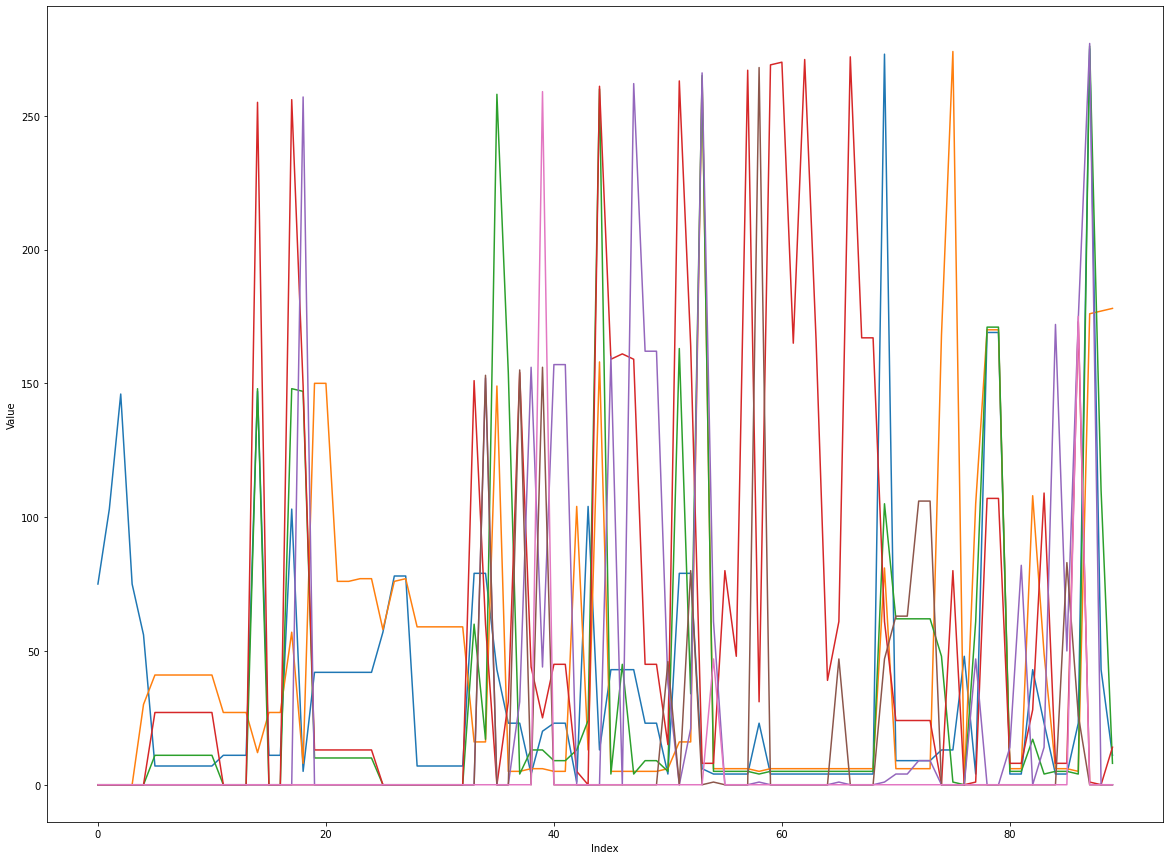

In [17]:
plt.figure(figsize=(20,15))
plt.plot(encoder_input_data)
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

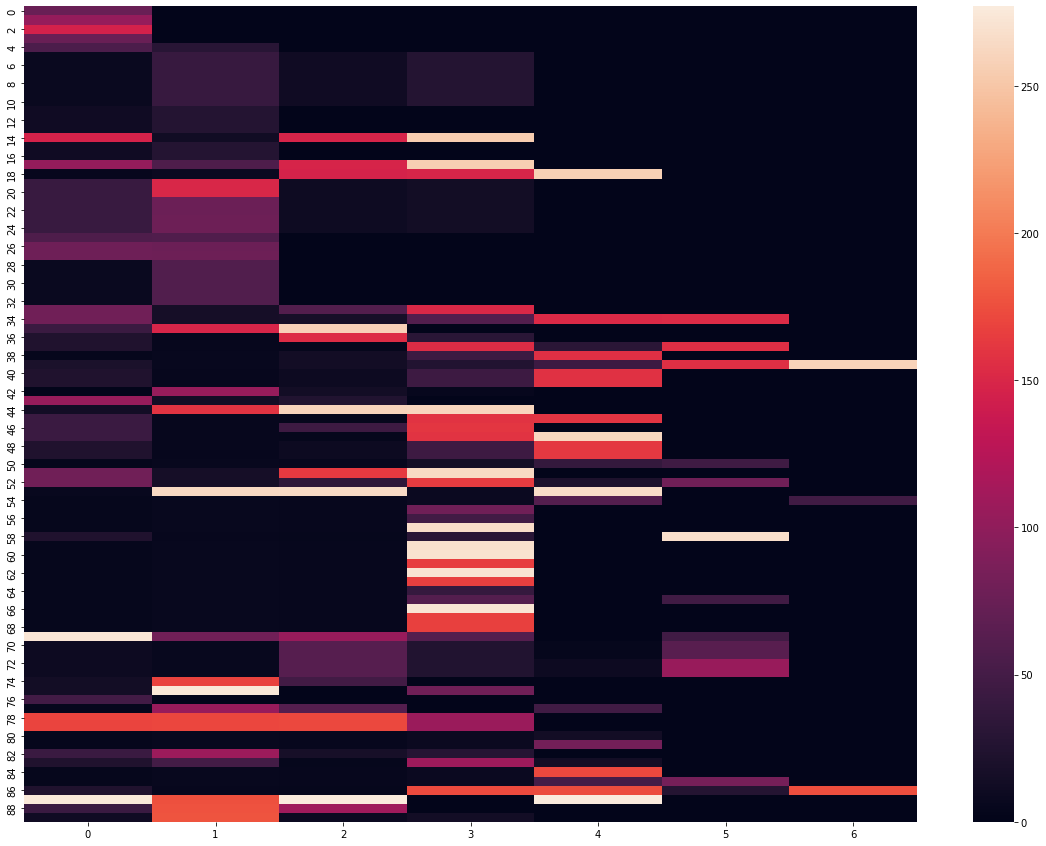

In [18]:
plt.figure(figsize=(20,15))
sns.heatmap(encoder_input_data)
plt.show()

In [19]:
encoder_input_data.shape

(90, 7)

In [20]:
# Converte respostas em sequencia de números usando o tokenizer
tokenized_answers = tokenizer.texts_to_sequences(answers)

# Calcula o comprimento máximo das sequências geradas
maxlen_answers = max([len(x) for x in tokenized_answers])

# Adiciona zeros ao final das sequências com comprimento menor que maxlen_answers
padded_answers = preprocessing.sequence.pad_sequences(tokenized_answers , maxlen=maxlen_answers , padding='post')

# Transforma a lista de sequências com zeros adicionais em um array numpy e armazena em decoder_input_data
decoder_input_data = np.array(padded_answers)

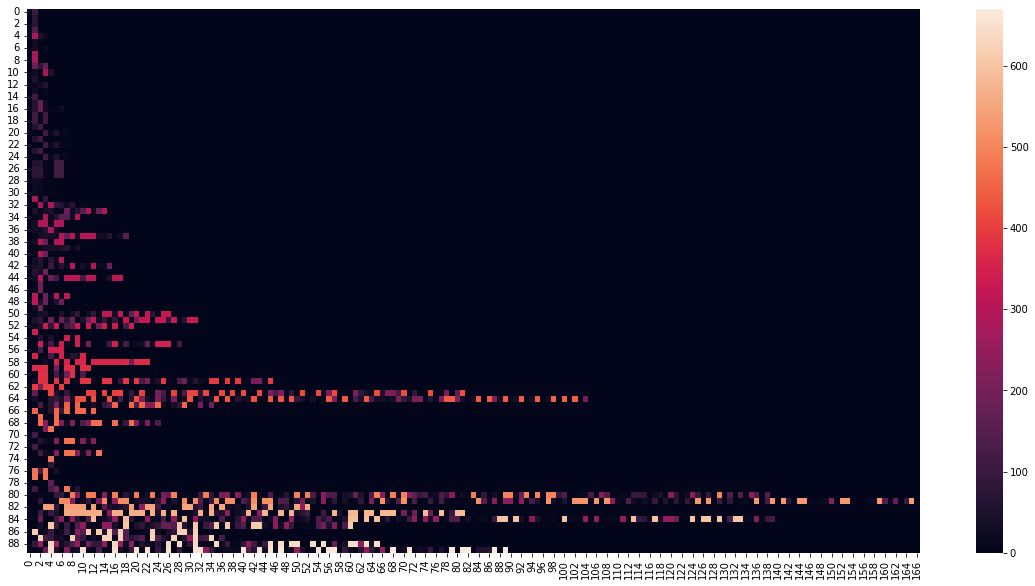

In [21]:
plt.figure(figsize=(20,10))
sns.heatmap(decoder_input_data)
plt.show()

In [22]:
decoder_input_data.shape

(90, 167)

In [23]:
# Converte respostas em sequencia de números usando o tokenizer
tokenized_answers = tokenizer.texts_to_sequences(answers)

# Remove o primeiro elemento de cada sequência
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]

# Adiciona zeros ao final das sequências com comprimento menor que maxlen_answers
padded_answers = preprocessing.sequence.pad_sequences(tokenized_answers , maxlen=maxlen_answers , padding='post')

# Transforma cada número da sequência em um vetor one-hot
onehot_answers = utils.to_categorical(padded_answers , VOCAB_SIZE)

# Transforma a lista de sequências one-hot em um array numpy e armazena em decoder_output_data
decoder_output_data = np.array(onehot_answers)

In [24]:
decoder_output_data.shape

(90, 167, 671)

In [25]:
# Calcular a distribuição de palavras nas perguntas
word_counts_questions = Counter(" ".join(questions).split())

# Calcular a distribuição de palavras nas respostas
word_counts_answers = Counter(" ".join(answers).split())

# Cria o gráfico de barras para perguntas
fig1 = go.Figure(data=[go.Bar(x=list(word_counts_questions.keys()),
                             y=list(word_counts_questions.values()))])
fig1.update_layout(title='Distribuição de palavras nas perguntas')

# Cria o gráfico de barras para respostas
fig2 = go.Figure(data=[go.Bar(x=list(word_counts_answers.keys()),
                             y=list(word_counts_answers.values()))])
fig2.update_layout(title='Distribuição de palavras nas respostas')

# Exibe o gráfico
fig1.show()
fig2.show()

In [26]:
num_questions = [len(questions)]
num_answers = [len(answers)]

# Cria o gráfico de barras
data = [go.Bar(x=['Perguntas', 'Respostas'], y=[num_questions, num_answers])]

# Define o título e eixos do gráfico
layout = go.Layout(title='Número de perguntas e respostas', xaxis=dict(title='Tipo'), yaxis=dict(title='Número'))

# Cria o objeto Figure
fig = go.Figure(data=data, layout=layout)

# Plota o gráfico
fig.show()

In [27]:
# Define o input layer para o encoder com o formato `(maxlen_questions,)`
encoder_inputs = tf.keras.layers.Input(shape=(maxlen_questions ,))

# Adiciona uma camada de embedding para o encoder com um tamanho de vocabulário de `VOCAB_SIZE` e uma dimensão de 200 e configurado para usar máscaras com valor zero.
encoder_embedding = tf.keras.layers.Embedding(VOCAB_SIZE, 200 , mask_zero=True) (encoder_inputs)

# Adiciona uma camada LSTM com 200 unidades e configurado para retornar o estado interno (state_h e state_c).
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM(200 , return_state=True)(encoder_embedding)

# Armazena os estados internos (state_h e state_c) retornados pela camada LSTM do encoder.
encoder_states = [ state_h , state_c ]

# Define o input layer para o decodificador com o formato `(maxlen_answers,)`
decoder_inputs = tf.keras.layers.Input(shape=(maxlen_answers , ))

# Adiciona uma camada de embedding para o decodificador com um tamanho de vocabulário de `VOCAB_SIZE` e uma dimensão de 200 e configurado para usar máscaras com valor zero.
decoder_embedding = tf.keras.layers.Embedding(VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)

# Adiciona uma camada LSTM com 200 unidades e configurado para retornar o estado interno (state_h e state_c), e também para retornar as sequências.
decoder_lstm = tf.keras.layers.LSTM(200 , return_state=True , return_sequences=True)

# Conecta a camada LSTM do decodificador com os estados internos armazenados anteriormente.
decoder_outputs , _ , _ = decoder_lstm (decoder_embedding , initial_state=encoder_states)



# Adiciona uma camada densa com VOCAB_SIZE unidades e função de ativação softmax, essa camada é responsável por fornecer a saída final para a cada passo do decodificador
decoder_dense = tf.keras.layers.Dense(VOCAB_SIZE , activation=tf.keras.activations.softmax) 
output = decoder_dense (decoder_outputs)

# Define o modelo como uma instância de Model do Keras
model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output)

2023-01-29 22:10:45.702100: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 22:10:45.790114: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 22:10:45.790896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-29 22:10:45.792058: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [28]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 7)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 167)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 7, 200)       134200      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 167, 200)     134200      input_2[0][0]                    
______________________________________________________________________________________________

In [30]:
model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=16, epochs=500) 

Epoch 1/500


2023-01-29 22:10:50.079632: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-29 22:10:56.692780: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


6/6 [==============================] - 9s 37ms/step - loss: 0.7872 - accuracy: 0.0440
Epoch 2/500
6/6 [==============================] - 0s 24ms/step - loss: 0.7800 - accuracy: 0.1083
Epoch 3/500
6/6 [==============================] - 0s 31ms/step - loss: 0.7363 - accuracy: 0.0786
Epoch 4/500
6/6 [==============================] - 0s 27ms/step - loss: 0.6909 - accuracy: 0.0566
Epoch 5/500
6/6 [==============================] - 0s 26ms/step - loss: 0.6724 - accuracy: 0.0643
Epoch 6/500
6/6 [==============================] - 0s 28ms/step - loss: 0.6653 - accuracy: 0.0825
Epoch 7/500
6/6 [==============================] - 0s 37ms/step - loss: 0.6602 - accuracy: 0.0522
Epoch 8/500
6/6 [==============================] - 0s 28ms/step - loss: 0.6568 - accuracy: 0.0797
Epoch 9/500
6/6 [==============================] - 0s 28ms/step - loss: 0.6537 - accuracy: 0.1050
Epoch 10/500
6/6 [==============================] - 0s 26ms/step - loss: 0.6498 - accuracy: 0.0990
Epoch 11/500
6/6 [=============

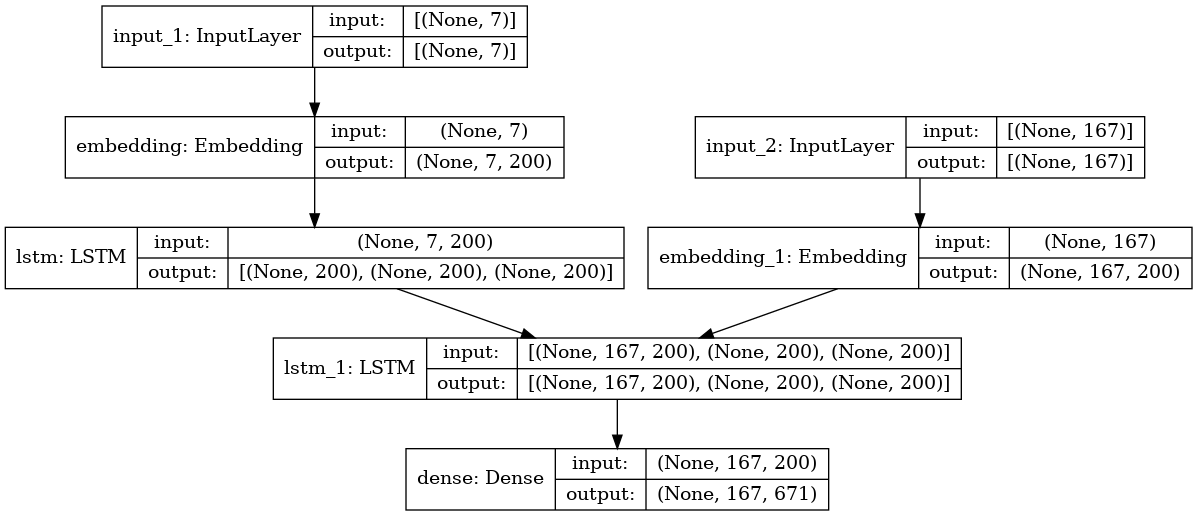

In [31]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [32]:
def inference():
    # cria um modelo separado para o codificador
    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)
    
    #entradas de estado para o decodificador
    decoder_state_input_h = tf.keras.layers.Input(shape=(200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=(200 ,))

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    
    #cria o modelo de decodificador
    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    
    decoder_model = tf.keras.models.Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)
    
    return encoder_model , decoder_model

def preprocess_input(input_sentence):
    #converter a sentença de entrada em uma lista de fichas
    tokens = input_sentence.lower().split()
    tokens_list = []
    for word in tokens:
        tokens_list.append(tokenizer.word_index[word])
        #Enche a lista de tokens e a retorna
    return preprocessing.sequence.pad_sequences([tokens_list] , maxlen=maxlen_questions , padding='post')

In [33]:
enc_model , dec_model = inference()

In [39]:
tests = []
while True:
    input_sentence = input("Input: ")
    tests.append(input_sentence)
    for i, input_sentence in enumerate(tests):
        states_values = enc_model.predict(preprocess_input(input_sentence))
        
    empty_target_seq = np.zeros((1 , 1))
    empty_target_seq[0, 0] = tokenizer.word_index['start']
    stop_condition = False
    decoded_translation = ''

    while not stop_condition :
        dec_outputs , h , c = dec_model.predict([empty_target_seq] + states_values)
        sampled_word_index = np.argmax(dec_outputs[0, -1, :])
        sampled_word = None

        for word , index in tokenizer.word_index.items() :
            if sampled_word_index == index :
                decoded_translation += f' {word}'
                sampled_word = word

        if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
            stop_condition = True

        empty_target_seq = np.zeros((1 , 1))  
        empty_target_seq[0 , 0] = sampled_word_index
        states_values = [h , c] 
    print()
    decoded_translation = decoded_translation.split(' end')[0]
    print(f'Bot: {decoded_translation}')

Input:  oi



Bot:  olá


Input:  boa tarde



Bot:  boa tarde em que posso ajudar


Input:  boa noite



Bot:  boa noite em que posso ajudar


Input:  o que é



Bot:  a força pela qual cada massa ou partícula de matéria incluindo fótons atrai e é atraído por qualquer outra massa ou partícula de matéria


Input:  nao entendi?


KeyError: 'nao'